In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna
from tqdm import tqdm
from scipy import stats
import joblib

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import os
import re

In [5]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [6]:
random_seed = 42
early_stopping_round = 100

## funcs

In [7]:
def get_dataset(folder_paths: list, filename_features: str, filename_target: str):
    X = pd.DataFrame()
    y = pd.DataFrame()
    for folder in folder_paths:
        X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
        y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
        
        is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
        is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
        if is_unnamed:
            X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
        if is_unnamed_y:
            y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
        
        # if X_tmp.columns[0] != "y":
        #     col_y = np.ones(X_tmp.shape[0]) * 1000
        #     X_tmp.insert(0, "y", col_y)
        
        print(X_tmp.shape, y_tmp.shape)
        X = pd.concat([X, X_tmp], axis = 0)
        y = pd.concat([y, y_tmp], axis = 0)
    X.reset_index(inplace=True, drop=True)
    y.reset_index(inplace=True, drop=True)
    print(X.shape, y.shape)
    return X, y

In [8]:
def add_exp_num(X):
    tracers_num = len(np.unique(X["Tracer"]))
    distances_num = len(np.unique(X["distances"]))
    experiment_num = []
    for exp in range(X.shape[0]//(tracers_num*distances_num)):
        experiment_num.extend(list(np.ones(tracers_num*distances_num) * (exp + 1)))
    X["experiment_num"] = experiment_num
    return X

In [9]:
def data_split(X, y, test_size = 0.2, valid_size = None, eval_size = None, random_seed = random_seed):
    rng = np.random.default_rng(seed=random_seed)
    
    experiment_nums = X["experiment_num"].unique()
    total_experiments = len(experiment_nums)
    
    n_test = int(test_size * total_experiments)
    
    splits = {}
    remaining_exps = set(experiment_nums)
    
    test_experiments = set(rng.choice(list(remaining_exps), n_test, replace=False))
    remaining_exps -= test_experiments
    splits['test'] = {
        'X': X[X["experiment_num"].isin(test_experiments)].copy(),
        'y': None
    }
    
    if valid_size:
        n_valid = int(valid_size * (total_experiments - n_test))
        valid_experiments = set(rng.choice(list(remaining_exps), n_valid, replace=False))
        remaining_exps -= valid_experiments
        splits['valid'] = {
            'X': X[X["experiment_num"].isin(valid_experiments)].copy(),
            'y': None
        }
    
    if eval_size:
        n_eval = int(eval_size * (total_experiments - n_test - n_valid))
        eval_experiments = set(rng.choice(list(remaining_exps), n_eval, replace=False))
        remaining_exps -= eval_experiments
        
        splits['eval'] = {
            'X': X[X["experiment_num"].isin(eval_experiments)].copy(),
            'y': None
        }
    
    splits['train'] = {
        'X': X[X["experiment_num"].isin(remaining_exps)].copy(),
        'y': None
    }
    
    for split_name in splits:
        splits[split_name]['y'] = y.loc[splits[split_name]['X'].index].copy()
    
    split_shapes = [f"{name}: X{splits[name]['X'].shape}, y{splits[name]['y'].shape}" 
                   for name in ['train', 'test', 'valid', 'eval'] 
                   if name in splits]
    print(f"Split shapes: {', '.join(split_shapes)}")
    
    if valid_size and eval_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'], splits['eval']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'], splits['eval']['y'])
    elif valid_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'])
    else:
        return splits['train']['X'], splits['test']['X'], splits['train']['y'], splits['test']['y']

In [10]:
def del_outs(X, y):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [11]:
def make_means_target(X, y):
    y["c_mean_y"] = X["y"] - y["c_mean_y"]
    y["c_mean_z"] = X["z"] - y["c_mean_z"]
    return y

In [12]:
def del_columns(X, columns):
    X.drop(columns=columns, inplace=True)
    # return X


## begin

In [13]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [14]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [15]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [16]:
folder_paths = ["output_19_01_2025_2"]

In [21]:
X, y = get_dataset(folder_paths, filename_features, filename_target)

(2322432, 10) (2322432, 4)
(2322432, 10) (2322432, 4)


In [22]:
y = make_means_target(X, y)

In [23]:
y.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)

In [24]:
X = add_exp_num(X)

## Delete zeros

In [25]:
X, y = del_outs(X, y)

(2312849, 11) (2312849, 4)


## EDA

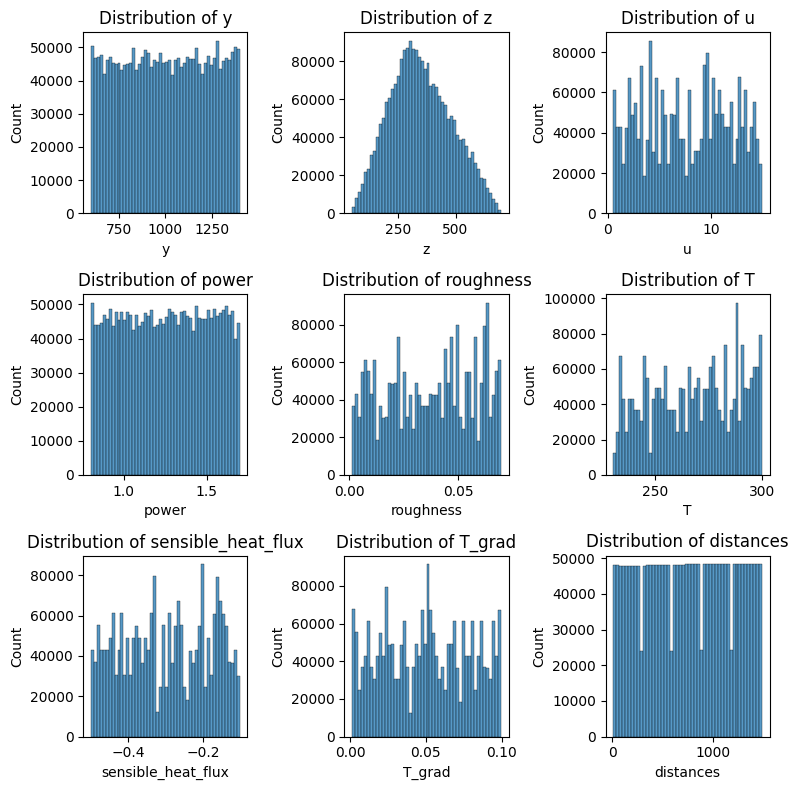

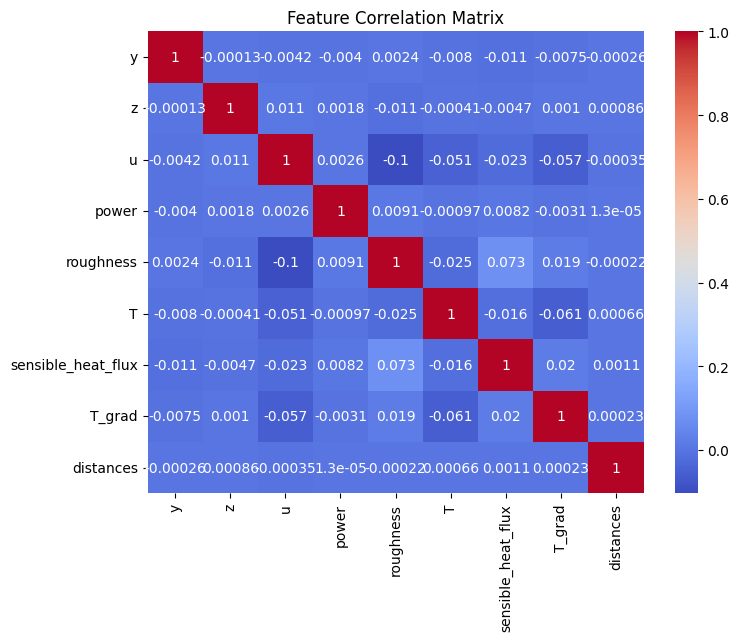

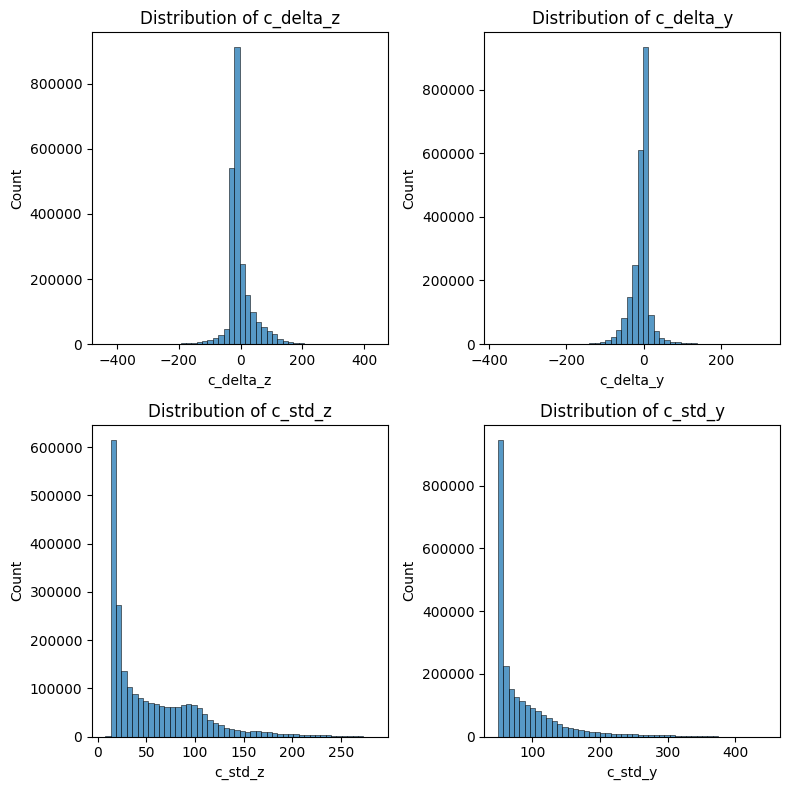

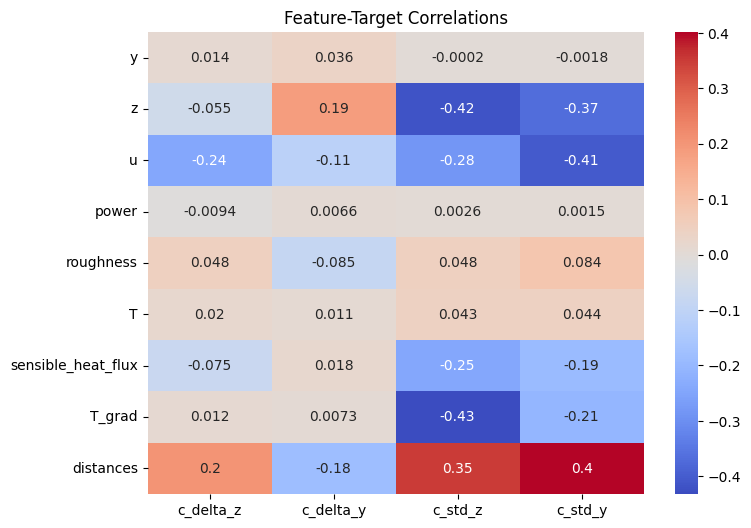

In [21]:
perform_eda(X[X.columns[1:-1]], y)

## Test-train split

In [26]:
# X_train, X_test, X_valid, X_eval, y_train, y_test, y_valid, y_eval = data_split(X, y, test_size=0.2, valid_size=0.2, eval_size=0.1)
X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)

Split shapes: train: X(1853505, 11), y(1853505, 4), test: X(459344, 11), y(459344, 4)


In [27]:
del_columns(X_train, ["experiment_num", "Tracer"])
del_columns(X_test, ["experiment_num", "Tracer"])
# del_columns(X_valid, ["experiment_num", "Tracer"])
# del_columns(X_eval, ["experiment_num", "Tracer"])

In [ ]:
# X_part, X_test, y_part, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_part, y_part, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

In [ ]:
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

In [ ]:
# perform_eda_short(X_test, y_test)

In [101]:
X_test_cut = X_test[X_test["distances"] > 490].copy()
y_test_cut = y_test.loc[X_test_cut.index]
X_train_cut = X_train[X_train["distances"] > 490].copy()
y_train_cut = y_train.loc[X_train_cut.index] 

## Feature engineering

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import quantile_transform, power_transform

In [29]:
class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-3):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        
        self.std_y_std = np.std(data["c_std_y"])
        self.std_z_std = np.std(data["c_std_z"])

        self.mean_y_mean = np.mean(data["c_delta_y"])
        self.mean_z_mean = np.mean(data["c_delta_z"])

        self.mean_y_std = np.std(data["c_delta_y"])
        self.mean_z_std = np.std(data["c_delta_z"])

        self.mean_y_minuses = data.index[data["c_delta_y"] < 0].to_list()
        self.mean_z_minuses = data.index[data["c_delta_z"] < 0].to_list()

        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias - self.near_zero
        data["c_std_z"] -= self.std_z_bias - self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])
        
        mean_y_sign = np.sign(data["c_delta_y"])
        data["c_delta_y"] = np.abs(data["c_delta_y"])       
        data["c_delta_y"] = np.log1p(data["c_delta_y"])
        # data["c_delta_y"] = np.log(data["c_delta_y"] + 1e-6)
        data["c_delta_y"]*=mean_y_sign
        
        data["c_delta_z"] = (data["c_delta_z"] - self.mean_z_mean)/self.mean_z_std
        mean_z_sign = np.sign(data["c_delta_z"])
        data["c_delta_z"]= mean_z_sign * np.log1p(np.abs(data["c_delta_z"]))
        # data["c_delta_z"]= mean_z_sign * np.log(np.abs(data["c_delta_z"]) + 1e-6)
        
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
        if "c_std_y" in data.columns:
            data["c_std_y"] = np.exp(data["c_std_y"])
            data["c_std_y"] += self.std_y_bias - self.near_zero

        if "c_std_z" in data.columns:
            data["c_std_z"] = np.expm1(data["c_std_z"])
            data["c_std_z"] += self.std_z_bias - self.near_zero
        
        if "c_delta_y" in data.columns:
            mean_y_sign = np.sign(data["c_delta_y"])
            data["c_delta_y"] = np.abs(data["c_delta_y"])
            data["c_delta_y"] = np.expm1(data["c_delta_y"])
            data["c_delta_y"] *=mean_y_sign
        if "c_delta_z" in data.columns:
            mean_z_sign = np.sign(data["c_delta_z"])
            data["c_delta_z"] = np.expm1(np.abs(data["c_delta_z"]))
            data["c_delta_z"] *=mean_z_sign
            data["c_delta_z"] = data["c_delta_z"] * self.mean_z_std + self.mean_z_mean
        return data


In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)

In [18]:
# y_train_1 = y_train.copy()
# target_pr = TargetPreprocessor()
# target_pr.fit(y_train_1)
# target_pr.transform(y_train_1)
# y_eval_1 = y_eval.copy()
# target_pr.transform(y_eval_1)
# target_pr.transform(y_valid)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

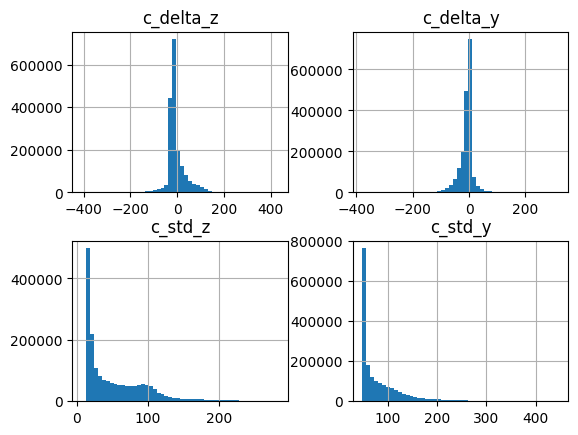

In [27]:
y_train.hist(bins=50)

In [32]:
y_1 = y_train.copy()

In [33]:
t_preproc = TargetPreprocessor()
# t_preproc.fit(y)
t_preproc.fit(y)
y_1 = t_preproc.transform(y_1)
print()
# perform_eda_short(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

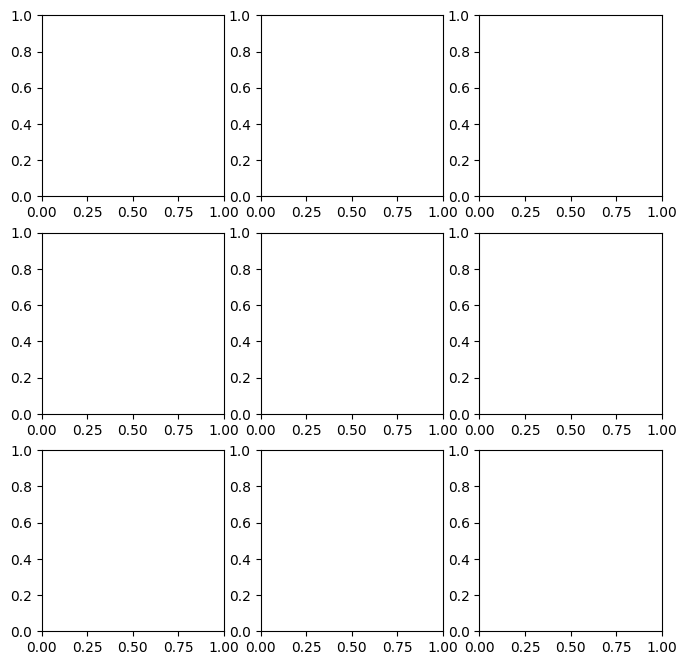

In [43]:
perform_eda_short(X_train_n, y_1)

In [44]:
y_1.isna().sum()

c_delta_z    0
c_delta_y    0
c_std_z      0
c_std_y      0
dtype: int64

In [112]:
t_preproc.inverse_transform(y_1)
print()

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

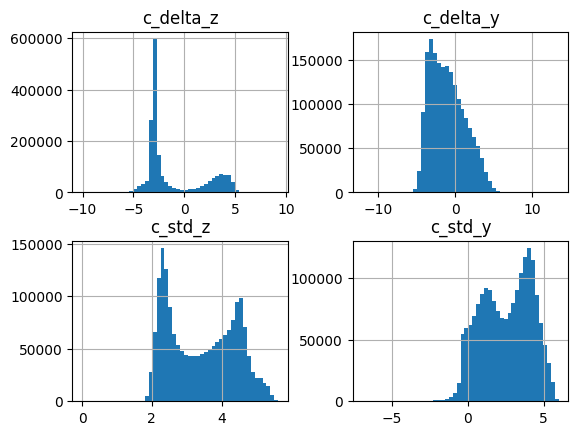

In [30]:
y_1.hist(bins=50)

In [31]:
np.sum(np.abs(y_train - y_1), axis=0) 

c_delta_z    4.743854e+07
c_delta_y    2.637670e+07
c_std_z      9.523762e+07
c_std_y      1.544898e+08
dtype: float64

In [ ]:
y_train.hist(bins=50)

In [ ]:
# t_preproc.transform(y_eval)
# t_preproc.transform(y_valid)

In [ ]:
perform_eda_short(X_train, y_train)

In [68]:
(y_train <= 0).sum(), (y_train > 0).sum() 

(c_mean_z    1263636
 c_mean_y     649248
 c_std_z           0
 c_std_y      109835
 dtype: int64,
 c_mean_z     589869
 c_mean_y    1204257
 c_std_z     1853505
 c_std_y     1743670
 dtype: int64)

In [ ]:
y_train

## Models

## Catboost with optuna

In [21]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'SymmetricTree',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, timeout=7200)

In [ ]:
print(study.best_value)
print(study.best_params)

In [13]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [14]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    # "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)

    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)
    
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

In [ ]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

In [ ]:
pd.DataFrame.from_dict(y_pred).hist(bins=100)

In [66]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[971.24424704]
[4.46791407]


## Random Forest

In [32]:
model_rf = RandomForestRegressor(n_jobs=32)

In [29]:
y_pred = {}
model_rf_dict = {}
for target in y_train.columns:
    model_rf_dict[target] = RandomForestRegressor(n_jobs=32)
    # model_rf_dict[target].fit(X_train, y_train[target])
    model_rf_dict[target].fit(X_train_n, y_1[target])
    # model_rf_dict[target].fit(X_train_cut, y_1[target])
    # y_tmp = model_rf_dict[target].predict(X_test_cut)
    y_tmp = model_rf_dict[target].predict(X_test_n)
    y_pred[target] = y_tmp

In [30]:
y_test_1 = y_test.copy()

In [35]:
y_test_1 = t_preproc.transform(y_test_1)

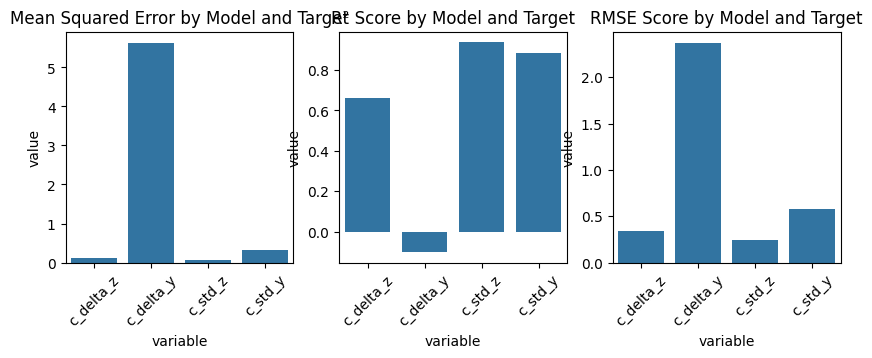

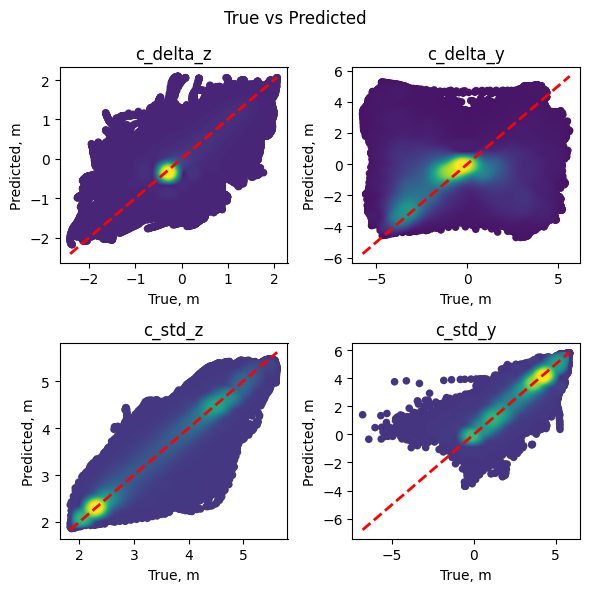

                mse        r2      rmse
c_delta_z  0.113199  0.661683  0.336450
c_delta_y  5.634040 -0.101821  2.373613
c_std_z    0.061467  0.937433  0.247926
c_std_y    0.330059  0.884693  0.574507


In [36]:
# t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test_1)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

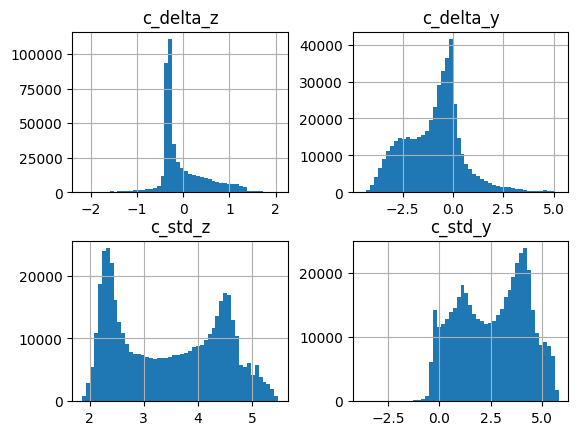

In [34]:
pd.DataFrame(y_pred).hist(bins=50)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

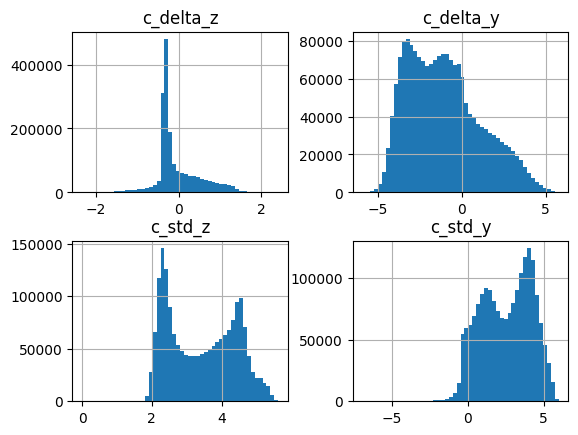

In [35]:
pd.DataFrame(y_1).hist(bins=50)

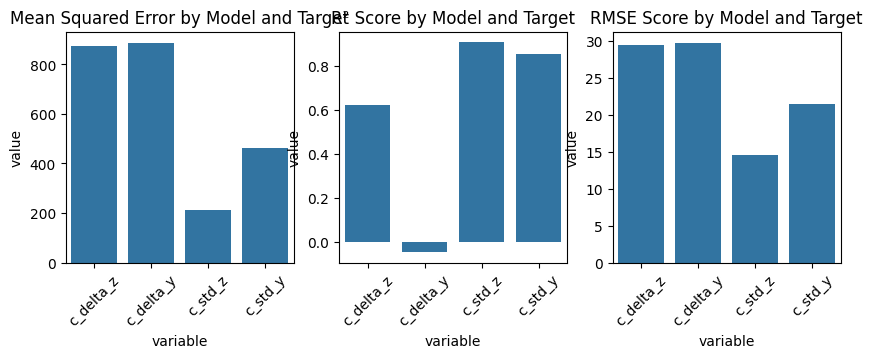

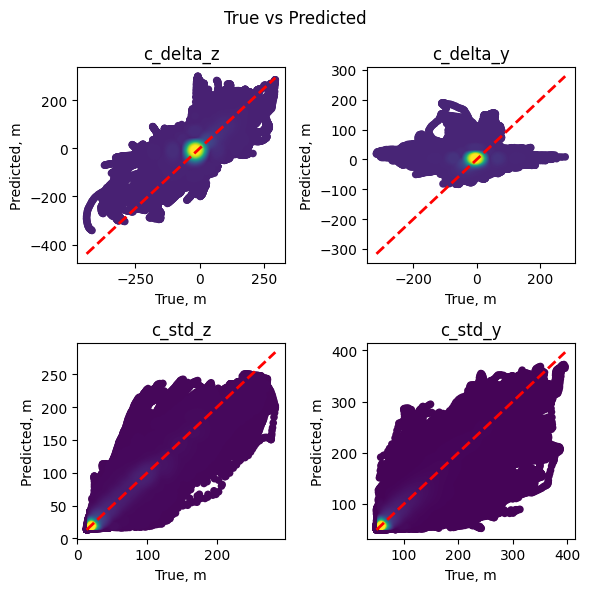

                  mse        r2       rmse
c_delta_z  872.444699  0.619945  29.537175
c_delta_y  887.858948 -0.047880  29.796962
c_std_z    211.039960  0.908125  14.527214
c_std_y    461.742719  0.854844  21.488200


In [34]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

## RF Feature Importance

In [31]:
import shap

In [30]:
X_test_n_pd = pd.DataFrame(data=X_test_n, columns=X_test.columns)

In [ ]:

# for target in y_train.columns:
#     explainer = shap.Explainer(model_rf_dict[target], X_test_n_pd)
#     shap_values = explainer(X_test_n_pd)
#     shap.plots.bar(shap_values, show=False)
#     plt.savefig(target +"f_i.png")

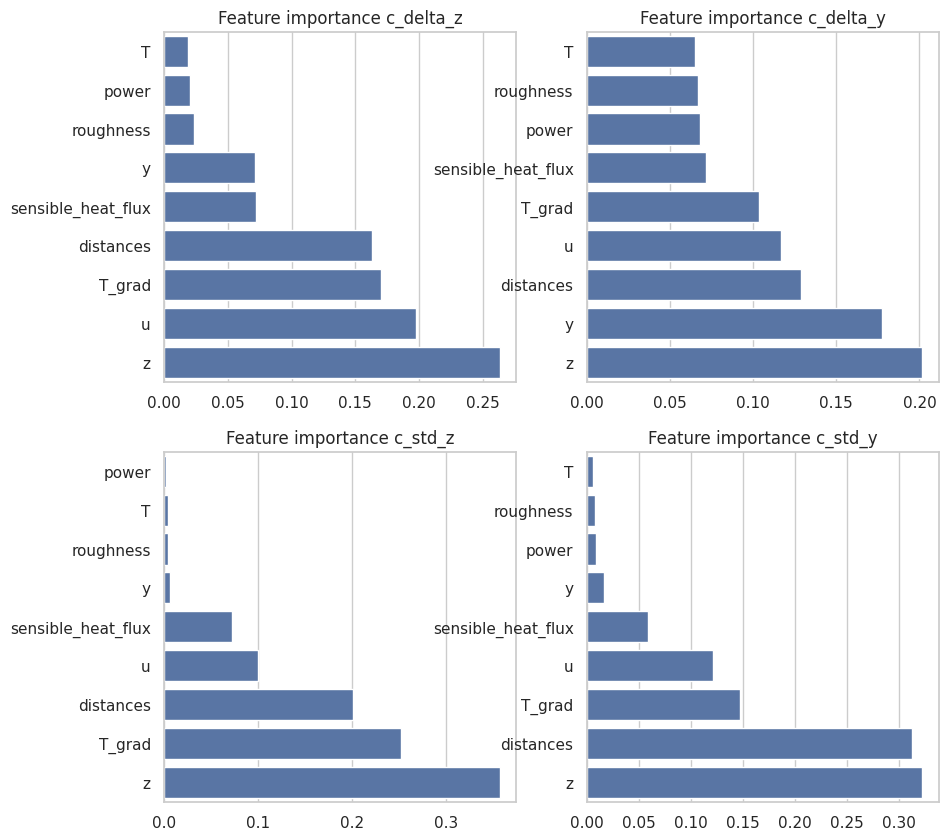

In [58]:
shape_col_t = 2        
shape_row_t = 2
fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(10, 10)) 
sns.set_theme(style="whitegrid")
for idx, col in enumerate(y_train.columns):
    row = idx // shape_col_t
    col_idx = idx % shape_row_t
    feature_importance = model_rf_dict[col].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    sns.barplot(x = feature_importance[sorted_idx], y=np.array(X_test.columns)[sorted_idx], ax=axes[row, col_idx])
    # axes[row, col_idx].set_yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    axes[row, col_idx].set_title(f'Feature importance {col}')


## Do it for means

In [ ]:
# y_pred = pd.DataFrame(y_pred).copy()
# y_pred.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]
# y_pred["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]

## -------------

In [ ]:
y_test.hist(bins=50)

In [ ]:
pd.DataFrame(y_pred).hist(bins=50)

## split distances

In [ ]:
# folder_paths = ["output_19_01_2025_2"]
filename_features_cut = "features.csv"
filename_target_23_4375 = "target-23_4375.csv"
filename_target_492_1875 = "target-492_1875.csv"
filename_target_1492_1875 = "target-1492_1875.csv"

In [49]:
features_23_4375, y_test_23_4375 = get_dataset(folder_paths, filename_features_cut, filename_target_23_4375)
features_492_1875, y_test_492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_492_1875)
features_1492_1875, y_test_1492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_1492_1875)

(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)


In [ ]:
plt.scatter(np.arange(1, len(y_test_23_4375["c_mean_y"]) +1), y_test_23_4375["c_mean_y"], color="r", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_492_1875["c_mean_y"]) +1), y_test_492_1875["c_mean_y"], color="b", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_1492_1875["c_mean_y"]) +1), y_test_1492_1875["c_mean_y"], color="g",alpha=0.5)

In [55]:
features_23_4375.drop(columns="Tracer", inplace=True)
features_492_1875.drop(columns="Tracer", inplace=True)
features_1492_1875.drop(columns="Tracer", inplace=True)

features_23_4375["distances"] = np.ones(features_23_4375.shape[0]) * 23.4375
features_492_1875["distances"] = np.ones(features_492_1875.shape[0]) * 492.1875
features_1492_1875["distances"] = np.ones(features_1492_1875.shape[0]) * 1492.1875


In [56]:
def del_zeros(X:pd.DataFrame, y: pd.DataFrame):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [57]:
features_23_4375, y_test_23_4375 = del_zeros(features_23_4375, y_test_23_4375)
features_492_1875, y_test_492_1875 = del_zeros(features_492_1875, y_test_492_1875)
features_1492_1875, y_test_1492_1875 = del_zeros(features_1492_1875, y_test_1492_1875)


(23752, 9) (23752, 4)
(22588, 9) (22588, 4)
(23673, 9) (23673, 4)


In [ ]:
# t_preproc.transform(y_test_23_4375)
# t_preproc.transform(y_test_492_1875)
# t_preproc.transform(y_test_1492_1875)

In [58]:
y_pred_23_4375 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_23_4375)
    y_pred_23_4375[target] = y_tmp

In [ ]:
t_preproc.inverse_transform(y_pred_23_4375)
performance_visualizations(y_pred_23_4375, y_test_23_4375)

In [ ]:
y_pred_492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_492_1875)
    y_pred_492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_492_1875)
performance_visualizations(y_pred_492_1875, y_test_492_1875)

In [ ]:
y_pred_1492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_1492_1875)
    y_pred_1492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_1492_1875)
performance_visualizations(y_pred_1492_1875, y_test_1492_1875)

## Linear

In [37]:
from sklearn.linear_model import LinearRegression

In [ ]:
y_pred = {}
model_l_dict ={}

for target in y_train.columns:
    model_l_dict[target] = LinearRegression()
    
    # model_l.fit(X_train, y_train[target])
    model_l_dict[target].fit(X_train_n, y_1[target])
    y_tmp = model_l_dict[target].predict(X_test_n)
    y_pred[target] = y_tmp

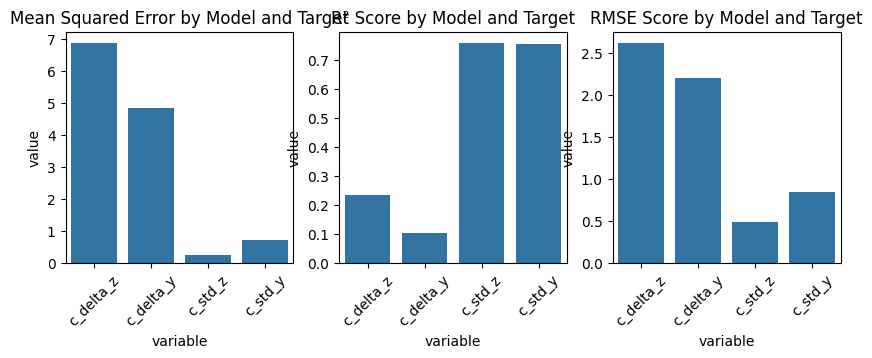

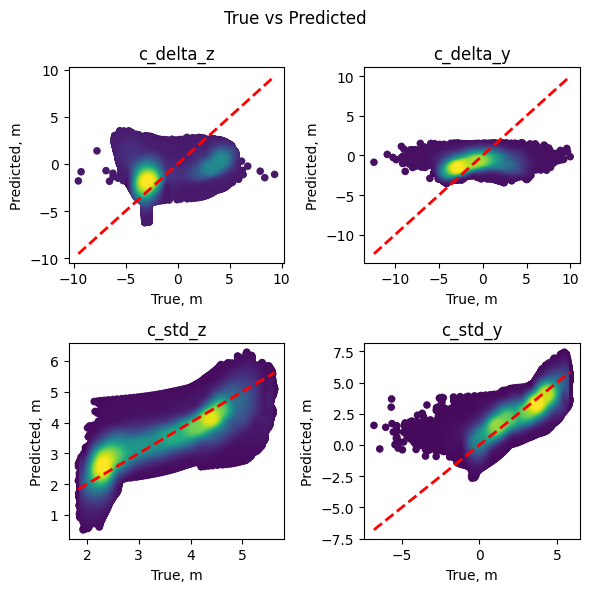

                mse        r2      rmse
c_delta_z  6.876869  0.233251  2.622379
c_delta_y  4.830762  0.101820  2.197900
c_std_z    0.236587  0.759181  0.486402
c_std_y    0.707651  0.752779  0.841220


In [39]:
# t_preproc.inverse_transform(y_pred)
y_test_1 = y_test.copy()
t_preproc.transform(y_test_1)
performance_visualizations(y_pred, y_test_1)

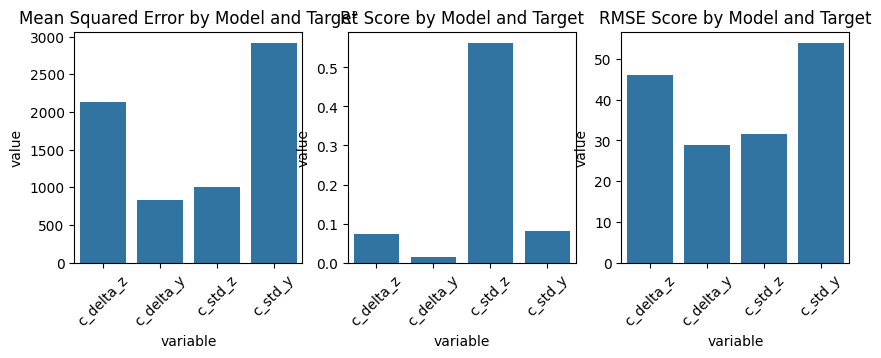

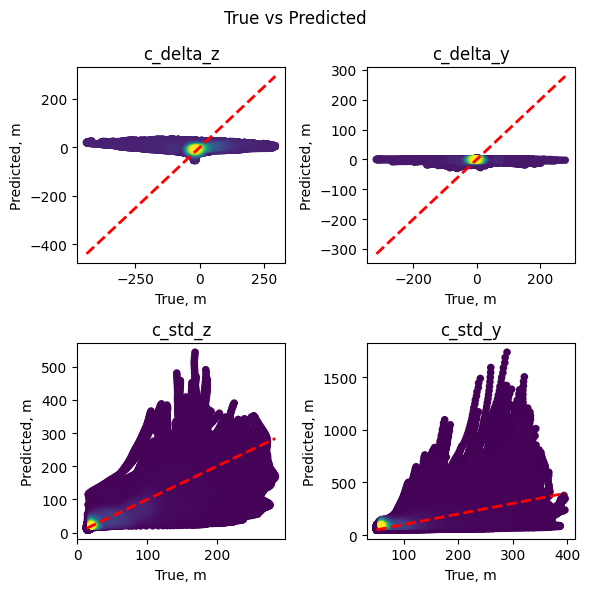

                   mse        r2       rmse
c_delta_z  2127.401872  0.073260  46.123767
c_delta_y   836.243908  0.013038  28.917882
c_std_z    1002.366521  0.563626  31.660172
c_std_y    2919.905196  0.082081  54.036147


In [39]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

## Linear Feature Importance

In [ ]:
shape_col_t = 2        
shape_row_t = 2
fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(10, 10)) 
sns.set_theme(style="whitegrid")
for idx, col in enumerate(y_train.columns):
    row = idx // shape_col_t
    col_idx = idx % shape_row_t
    feature_importance = model_l_dict[col].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    sns.barplot(x = feature_importance[sorted_idx], y=np.array(X_test.columns)[sorted_idx], ax=axes[row, col_idx])
    # axes[row, col_idx].set_yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    axes[row, col_idx].set_title(f'Feature importance {col}')

## Uncertainty of models

In [34]:
class UncertaintyRFEstimator:
    def __init__(self, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = RandomForestRegressor(n_estimators=100, n_jobs=64, random_state=random_state)

    def fit(self, X, y):
        y = np.array(y)
        self.base_model.fit(X, y)
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit a new model
            model = RandomForestRegressor(n_estimators=100, n_jobs=64, random_state=self.random_state+i)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        return self
    
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        y_pred_tmp = self.base_model.predict(X)
        y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_tmp)
        result['prediction'] = np.array(y_pred_tmp[self.target_name])

        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        # tree_predictions = []
        # for tree in self.base_model.estimators_:
        #     tree_predictions.append(tree.predict(X))
        # tree_predictions = np.array(tree_predictions)
        # result['tree_variance'] = np.var(tree_predictions, axis=0)
        
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        y_test = np.array(y_test)
        # Evaluate prediction intervals
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        # sorted_indices = np.argsort(predictions['std'])
        # sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # # Divide into bins and calculate average error in each bin
        # n_bins = 10
        # bin_size = len(sorted_indices) // n_bins
        # bin_errors = []
        # bin_stds = []
        
        # for i in range(n_bins):
        #     start_idx = i * bin_size
        #     end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
        #     bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
        #     bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        # eval_results['bin_errors'] = bin_errors
        # eval_results['bin_stds'] = bin_stds
        
        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, n_samples=None):
        y_test=np.array(y_test)
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        
        
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                np.abs(predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx]),
                np.abs(predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx])
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')
        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
            

    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

In [20]:
print("Running Random Forest Regression uncertainty estimation...")
for target in y_1.columns:
    rf_uncertainty = UncertaintyRFEstimator(t_preproc,target, n_bootstrap=10)
    rf_uncertainty.fit(X_train_n, y_1[target])
    # rf_predictions = rf_uncertainty.predict_with_uncertainty(X_test_n)
    rf_eval = rf_uncertainty.evaluate_uncertainty(X_test_n, y_test[target])

    print(f"Random Forest RMSE: {rf_eval['rmse']:.4f}")
    print(f"Interval coverage: {rf_eval['interval_coverage']:.4f} (expected: {rf_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    rf_uncertainty.visualize_uncertainty(X_test_n, y_test[target], n_samples=100)

Running Random Forest Regression uncertainty estimation...


NameError: name 'y_1' is not defined

In [ ]:
class UncertaintyLinEstimator:
    def __init__(self, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = LinearRegression(n_jobs=64, random_state=random_state)
    
    def fit(self, X, y):
        
        y = np.array(y)
        # Fit base model
        self.base_model.fit(X, y)
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            model = LinearRegression(n_jobs=64, random_state=self.random_state)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        return self
    
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        result['prediction'] = self.base_model.predict(X)
        
        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        
        # Calculate prediction intervals
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        
        y_pred_base = self.base_model.predict(X)
        y_pred_base = pd.DataFrame(data=y_pred_base, columns=[self.target_name])
        self.target_transformer.inverse_transform(y_pred_base)
        
        residual_std = np.sqrt(np.mean((result['prediction'] - y_pred_base) ** 2))
        
        # Approximate prediction intervals using residual standard error
        result['linear_lower_bound'] = result['prediction'] - 1.96 * residual_std
        result['linear_upper_bound'] = result['prediction'] + 1.96 * residual_std
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        sorted_indices = np.argsort(predictions['std'])
        sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # Divide into bins and calculate average error in each bin
        n_bins = 10
        bin_size = len(sorted_indices) // n_bins
        bin_errors = []
        bin_stds = []
        
        for i in range(n_bins):
            start_idx = i * bin_size
            end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
            bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
            bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        eval_results['bin_errors'] = bin_errors
        eval_results['bin_stds'] = bin_stds

        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, n_samples=None):
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx],
                predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx]
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title('Regression Predictions with Uncertainty')
        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Uncertainty vs. Error plot (if y_test is provided)
        if y_test_subset is not None:
            plt.figure(figsize=(8, 6))
            errors = np.abs(predictions['prediction'] - y_test_subset)
            plt.scatter(predictions['std'], errors, alpha=0.6)
            plt.xlabel('Prediction Standard Deviation')
            plt.ylabel('Absolute Error')
            plt.title('Uncertainty vs. Error')
            
            # Add trend line
            z = np.polyfit(predictions['std'], errors, 1)
            p = np.poly1d(z)
            plt.plot(np.sort(predictions['std']), p(np.sort(predictions['std'])), 
                    'r--', alpha=0.8)
            
            plt.tight_layout()
            plt.show()
            
            # Calibration plot for regression uncertainty
            eval_results = self.evaluate_uncertainty(X_test, y_test)
            plt.figure(figsize=(8, 6))
            plt.plot(eval_results['bin_stds'], eval_results['bin_errors'], 'o-')
            plt.plot([0, max(eval_results['bin_stds'])], [0, max(eval_results['bin_stds'])], 'r--')
            plt.xlabel('Mean Predicted Standard Deviation')
            plt.ylabel('Mean Absolute Error')
            plt.title('Uncertainty Calibration')
            plt.tight_layout()
            plt.show()
        
    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

In [ ]:
print("\nRunning Linear Regression uncertainty estimation...")

for target in y_1.columns:
    lin_uncertainty = UncertaintyLinEstimator(t_preproc,target, n_bootstrap=50)
    lin_uncertainty.fit(X_train_n, y_1[target])
    lin_uncertainty = lin_uncertainty.predict_with_uncertainty(X_test_n)
    lin_eval = lin_uncertainty.evaluate_uncertainty(X_test, y_test[target])

    print(f"Random Forest RMSE: {lin_eval['rmse']:.4f}")
    print(f"Interval coverage: {lin_eval['interval_coverage']:.4f} (expected: {lin_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    lin_uncertainty.visualize_uncertainty(X_test_n, y_test[target], n_samples=100)

## Catboost Uncertainty

In [ ]:
catboost_model_path = '/app/nse/catboost/' + 'outputs_09_03_2025/' + "models/"

In [ ]:
model_c_delta_y = CatBoostRegressor()
model_c_delta_z = CatBoostRegressor()
model_c_std_y = CatBoostRegressor()
model_c_std_z = CatBoostRegressor()

model_c_delta_y.load_model(catboost_model_path + "catboost_c_delta_y.cbm")
model_c_delta_z.load_model(catboost_model_path + "catboost_c_delta_z.cbm")
model_c_std_y.load_model(catboost_model_path + "catboost_c_std_y.cbm")
model_c_std_z.load_model(catboost_model_path + "catboost_c_std_z.cbm")

params_c_delta_y = model_c_delta_y.get_params()
params_c_delta_z = model_c_delta_z.get_params()  
params_c_std_y = model_c_std_y.get_params()  
params_c_std_z = model_c_std_z.get_params()  

In [ ]:
print(params_c_std_z)

In [ ]:
class UncertaintyCbEstimator:
    def __init__(self, params, target_transformer, target_name, n_bootstrap=100, alpha=0.05, random_state=42):
        self.n_bootstrap = n_bootstrap
        self.alpha = alpha
        self.random_state = random_state
        self.models = []
        self.base_model = None
        self.params = params
        self.target_transformer = target_transformer
        self.target_name = target_name
        self.base_model = CatBoostRegressor(**self.params)

    def fit(self, X, y):
        y = np.array(y)
        self.base_model.fit(X, y)
        
        # Bootstrap sampling for uncertainty estimation
        n_samples = X.shape[0]
        self.models = []
        
        for i in tqdm(range(self.n_bootstrap), desc="Fitting bootstrap models"):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Create and fit a new model
            model = CatBoostRegressor(**self.params)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        return self
    
    def predict_with_uncertainty(self, X):
        result = {}
        
        # Base model prediction
        result['prediction'] = self.base_model.predict(X)
        
        # Bootstrap-based uncertainty
        bootstrap_predictions = []
        for model in tqdm(self.models, desc="Generating bootstrap predictions"):
            
            y_pred_tmp = model.predict(X)
            y_pred_tmp = pd.DataFrame(data=y_pred_tmp, columns=[self.target_name])
            self.target_transformer.inverse_transform(y_pred_tmp)
            bootstrap_predictions.append(np.array(y_pred_tmp[self.target_name]))
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        
        result['mean'] = np.mean(bootstrap_predictions, axis=0)
        result['std'] = np.std(bootstrap_predictions, axis=0)
        lower_percentile = 100 * self.alpha / 2
        upper_percentile = 100 * (1 - self.alpha / 2)
        result['lower_bound'] = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
        result['upper_bound'] = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
        # tree_predictions = []
        # for tree in self.base_model.estimators_:
        #     tree_predictions.append(tree.predict(X))
        # tree_predictions = np.array(tree_predictions)
        # result['tree_variance'] = np.var(tree_predictions, axis=0)
        
        
        return result
    
    def evaluate_uncertainty(self, X_test, y_test):
        predictions = self.predict_with_uncertainty(X_test)
        eval_results = {}
        y_test = np.array(y_test)
        # Evaluate prediction intervals
        in_interval = np.logical_and(
            y_test >= predictions['lower_bound'],
            y_test <= predictions['upper_bound']
        )
        eval_results['interval_coverage'] = np.mean(in_interval)
        eval_results['expected_coverage'] = 1 - self.alpha
        
        # Calculate RMSE
        eval_results['rmse'] = np.sqrt(mean_squared_error(y_test, predictions['prediction']))
        
        # Calculate uncertainty calibration for regression
        # Sort predictions by uncertainty (std)
        sorted_indices = np.argsort(predictions['std'])
        sorted_errors = np.abs(y_test - predictions['prediction'])[sorted_indices]
        
        # Divide into bins and calculate average error in each bin
        n_bins = 10
        bin_size = len(sorted_indices) // n_bins
        bin_errors = []
        bin_stds = []
        
        for i in range(n_bins):
            start_idx = i * bin_size
            end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(sorted_indices)
            bin_errors.append(np.mean(sorted_errors[start_idx:end_idx]))
            bin_stds.append(np.mean(predictions['std'][sorted_indices[start_idx:end_idx]]))
        
        eval_results['bin_errors'] = bin_errors
        eval_results['bin_stds'] = bin_stds
        
        return eval_results
    
    def visualize_uncertainty(self, X_test, y_test=None, n_samples=None):
        if n_samples is not None and n_samples < X_test.shape[0]:
            indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
            X_test_subset = X_test[indices]
            y_test_subset = y_test[indices] if y_test is not None else None
        else:
            X_test_subset = X_test
            y_test_subset = y_test
        
        predictions = self.predict_with_uncertainty(X_test_subset)
        
        
        # Sort by prediction for clearer visualization
        sort_idx = np.argsort(predictions['prediction'])
        
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            np.arange(len(sort_idx)),
            predictions['prediction'][sort_idx],
            yerr=[
                predictions['prediction'][sort_idx] - predictions['lower_bound'][sort_idx],
                predictions['upper_bound'][sort_idx] - predictions['prediction'][sort_idx]
            ],
            fmt='o', alpha=0.6, ecolor='lightgray', capsize=3
        )
        
        if y_test_subset is not None:
            plt.scatter(np.arange(len(sort_idx)), y_test_subset[sort_idx], 
                        c='red', marker='x', label='Actual')
        
        plt.xlabel('Sample Index (sorted by prediction)')
        plt.ylabel('Prediction')
        plt.title(f'Predictions with Uncertainty, {self.target_name}')
        if y_test_subset is not None:
            plt.legend()
        plt.tight_layout()
        plt.show()
            

    
    def save(self, filename):
        """Save the model and related objects"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved model"""
        return joblib.load(filename)

In [ ]:
print("Running CatBoost Regression uncertainty estimation...")
for target in y_1.columns:
    rf_uncertainty = UncertaintyCbEstimator(t_preproc,target, n_bootstrap=10)
    rf_uncertainty.fit(X_train_n, y_1[target])
    rf_predictions = rf_uncertainty.predict_with_uncertainty(X_test_n)
    rf_eval = rf_uncertainty.evaluate_uncertainty(X_test_n, y_test[target])

    print(f"Random Forest RMSE: {rf_eval['rmse']:.4f}")
    print(f"Interval coverage: {rf_eval['interval_coverage']:.4f} (expected: {rf_eval['expected_coverage']:.4f})")

    # Visualize with a subset of samples for clarity
    rf_uncertainty.visualize_uncertainty(X_test_n, y_test[target], n_samples=100)